# 2. External stresses
In this notebook you will learn:
- how to add external stresses (water level fluctuation, well extractions and a step trend) to a time series model.
- how to visualise the contributions of multiple external stresses.
- how to simulate groundwater levels using a time series model.

### Contents
1. [Create a basic model](#basicmodel)
2. [Surface water levels](#surfacewater)
3. [Extraction wells](#well)
4. [Simulate groundwater levels](#simulate)
5. [Step trend](#step)
6. [Recharge](#recharge)

In [1]:
# importeer de benodigde packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pastas as ps
%matplotlib inline

### 1. A basic model<a name="basicmodel"></a>
We create a basic model using the method described in [1_basic_pastas_model](1_basic_pastas_model.ipynb) and the time series in the directory `data/nb2`. <BR><sub>when solving we use `noise=False`. This means we don't use a noisemodel. A noisemodel can be used to obtain statistical information of the time series model. For this exercises we don't use a model and we don't use this information.<sub>

INFO: Cannot determine frequency of series head
INFO: Inferred frequency from time series None: freq=D 


Model Results head                Fit Statistics
nfev     19                     EVP        64.39
nobs     3015                   R2          0.64
noise    False                  RMSE        0.17
tmin     2010-01-01 00:00:00    AIC          nan
tmax     2018-04-05 00:00:00    BIC          nan
freq     D                      ___             
warmup   3650 days 00:00:00     ___             
solver   LeastSquares           ___             

Parameters (4 were optimized)
               optimal  stderr     initial  vary
recharge_A  337.470787  ±3.61%  208.540395  True
recharge_n    0.982502  ±2.59%    1.000000  True
recharge_a   97.501004  ±6.93%   10.000000  True
constant_d    8.693536  ±0.08%    8.863658  True

Parameter correlations |rho| > 0.5
recharge_A recharge_n -0.68
           recharge_a  0.89
           constant_d -0.88
recharge_n recharge_a -0.89
           constant_d  0.59
recharge_a constant_d -0.78


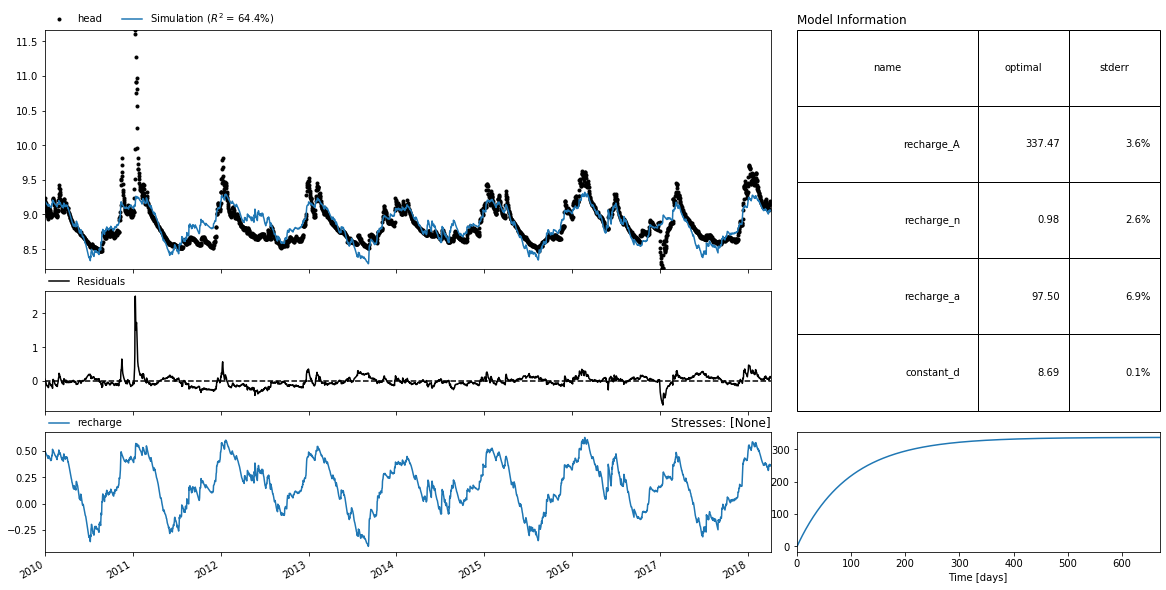

In [2]:
oseries1 = pd.read_csv("data/nb2/groundwater.csv",
                       parse_dates=True,  squeeze=True, index_col=0)
rain1 = pd.read_csv("data/nb2/rain.csv", parse_dates=True,
                    squeeze=True, index_col=0)
evap1 = pd.read_csv("data/nb2/evap.csv", parse_dates=True,
                    dayfirst=True, squeeze=True, index_col=0)

ml1 = ps.Model(oseries1)
sm1 = ps.StressModel(rain1-evap1, rfunc=ps.Gamma, name="recharge")
ml1.add_stressmodel(sm1)
ml1.solve(noise=False)
ml1.plots.results(figsize=(16, 8))

#### Exercise 1 <a name="ex1"></a>
In the results of this basic model we can see that there is a poor fit between simulated and observed groundwater heads at the start of 2017. What could be the reason for this poor fit?

<a href="#ans1">Answer Exercise 1</a>

### 2. Surface water levels<a name="surfacewater"></a>

In order to simulate the groundwater heads more accurately we have to incorporate the surface water levels in our time series model. 

#### Exercise 2 <a name="ex2"></a>
There is a file in the `data/nb2` folder named `waterlevel.csv` with the surface water levels. Read the surface water levels and visualise them together with the groundwater heads, evaporation and precipitation.

<a href="#ans2">Answer Exercise 2</a>

Now that we have the surface water levels we can include them in the time series model. We follow these steps:
1. Add a stressmodel using the `waterlevel` series and a response function `Exponential` in this case. The `Exponential` response function is often used to mimick the response of the groundwater to changes in surface water levels.
2. Normalize the stress in the stress model. We do this in order to use only the variation in waterlevels in our model and not it's absolute value.
3. Add the stressmodel to the existing time series model (which already contains a recharge stress model).
4. Solve the model.

In [3]:
waterlevel = pd.read_csv("data/nb2/waterlevel.csv",
                         parse_dates=True,  squeeze=True, index_col=0)

ml_wlvl = ml1.copy()
w = ps.StressModel(waterlevel, rfunc=ps.Exponential,
                   name="waterlevel", settings="waterlevel")

# Normalize the stress
w.update_stress(norm="mean")

ml_wlvl.add_stressmodel(w)
ml_wlvl.solve(noise=False)

INFO: Cannot determine frequency of series head
INFO: Inferred frequency from time series  Waterlevel: freq=D 


Model Results head_copy             Fit Statistics
nfev     34                     EVP          86.62
nobs     3015                   R2            0.87
noise    False                  RMSE          0.11
tmin     2010-01-01 00:00:00    AIC            nan
tmax     2018-04-05 00:00:00    BIC            nan
freq     D                      ___               
warmup   3650 days 00:00:00     ___               
solver   LeastSquares           ___               

Parameters (6 were optimized)
                 optimal  stderr     initial  vary
recharge_A    291.177948  ±3.08%  208.540395  True
recharge_n      1.078898  ±2.13%    1.000000  True
recharge_a    100.504293  ±5.51%   10.000000  True
waterlevel_A    0.386527  ±1.46%    2.547063  True
waterlevel_a    1.447653  ±6.71%   10.000000  True
constant_d      8.717912  ±0.05%    8.863658  True

Parameter correlations |rho| > 0.5
recharge_A recharge_n -0.73
           recharge_a  0.90
           constant_d -0.91
recharge_n recharge_a -0.91
     

#### Exercise 3<a name="ex3"></a>
Plot the results of the model with the surface water levels. What do you see?

<a href="#ans3">Answer Exercise 3</a>

### 3. Extraction wells <a name="well"></a>
Extraction wells are another external factor that can influence the groundwater levels over time. In the code cell below a time series model is created from observed groundwater levels. These groundwaterlevels are also influenced by the extraction rates of a nearby well. The extraction rates are not incorporated in the model yet. 

INFO: Cannot determine frequency of series  Head
INFO: Inferred frequency from time series  Prec: freq=D 
INFO: Inferred frequency from time series  Evap: freq=D 


Model Results  Head                 Fit Statistics
nfev     28                     EVP          44.49
nobs     3869                   R2            0.09
noise    True                   RMSE          0.34
tmin     1995-01-14 00:00:00    AIC           9.51
tmax     2018-01-12 00:00:00    BIC          47.07
freq     D                      ___               
warmup   3650 days 00:00:00     ___               
solver   LeastSquares           ___               

Parameters (6 were optimized)
                optimal   stderr     initial  vary
recharge_A   365.179436  ±10.93%  203.104730  True
recharge_n     1.406847   ±1.68%    1.000000  True
recharge_a    44.211227   ±9.59%   10.000000  True
recharge_f    -0.592312  ±12.97%   -1.000000  True
constant_d    15.273114   ±0.89%   15.975755  True
noise_alpha  358.234197  ±32.07%    1.000000  True

Parameter correlations |rho| > 0.5
recharge_A recharge_a  0.87
           recharge_f  0.60
           constant_d -0.56
recharge_n recharge_a -0.62
recha

''

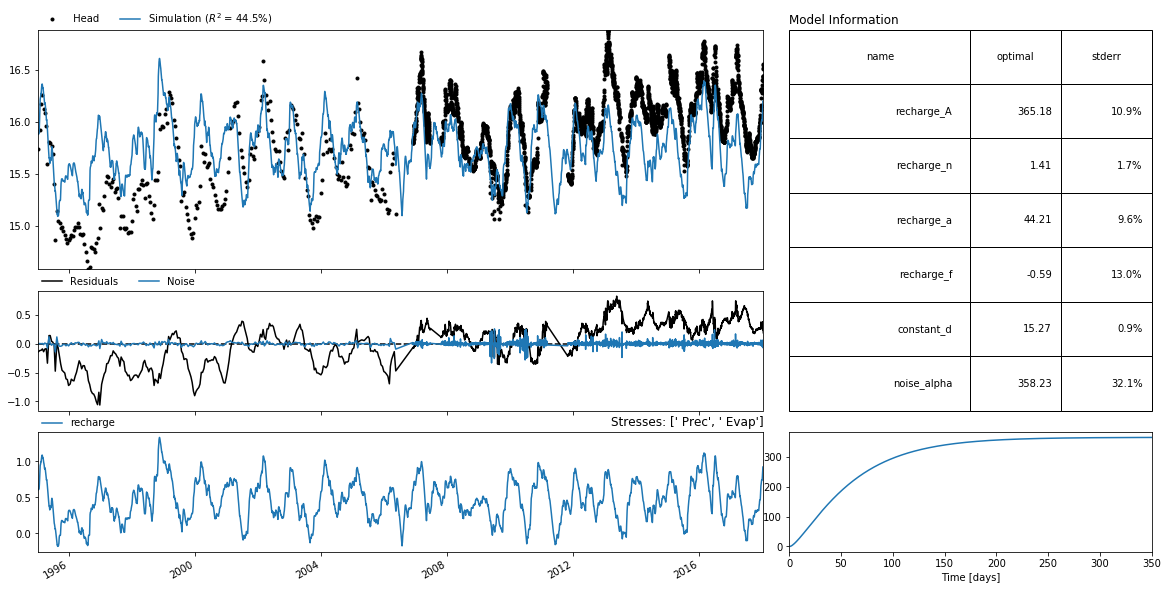

In [60]:
oseries2 = pd.read_csv("data/nb2/head_wellex.csv",
                       parse_dates=True,  squeeze=True, index_col=0)
rain2 = pd.read_csv("data/nb2/prec_wellex.csv",
                    parse_dates=True, squeeze=True, index_col=0)
evap2 = pd.read_csv("data/nb2/evap_wellex.csv", parse_dates=True,
                    dayfirst=True, squeeze=True, index_col=0)

ml2 = ps.Model(oseries2)
sm2 = ps.StressModel2([rain2, evap2], rfunc=ps.Gamma, name="recharge")
ml2.add_stressmodel(sm2)
ml2.solve()
ml2.plots.results(figsize=(16, 8))
;

#### Exercise 4 <a name="ex4"></a>
Add the well extraction rates to the model and solve the model. The extraction rates can be obtained from the file `well_wellex.csv` in the `data/nb2 folder`. Use the `Hantush` response function when creating the `Stressmodel`.

<a href="#ans4">Answer Exercise 4</a>

#### Exercise 5 <a name="ex5"></a>

The simulated groundwater heads are obtained from the individual contributions based on superposition. Visualise the contribution of the stresses using the `decomposition` function In the `plots` submodule. 

<sup>Use [1_basic_pastas_model chapter 5](1_basic_pastas_model.ipynb#visualise) as a reference if you forgot about plotting.<sup>

<a href="#ans5">Answer Exercise 5</a>

### 4. Simulate groundwater levels<a name="simulate"></a>
We can simulate groundwater levels with the pastas model using the `simulate()` method. In the `simulate` method you can specify the period that you are simulating with the arguments `tmin` and `tmax`. By default the period in which you have observations is simulated. This is also the period that the model was calibrated for. The example below shows how the `simulate` method is used to obtain simulations from different pastas models and compare them.

INFO: Cannot determine frequency of series  Head
INFO: Inferred frequency from time series  Well: freq=D 


Model Results  Head_copy            Fit Statistics
nfev     46                     EVP          75.30
nobs     3869                   R2            0.75
noise    True                   RMSE          0.18
tmin     1995-01-14 00:00:00    AIC          15.52
tmax     2018-01-12 00:00:00    BIC          71.87
freq     D                      ___               
warmup   3650 days 00:00:00     ___               
solver   LeastSquares           ___               

Parameters (9 were optimized)
                optimal   stderr     initial  vary
recharge_A   534.274964   ±9.64%  203.104730  True
recharge_n     1.368282   ±1.55%    1.000000  True
recharge_a    65.043043   ±8.61%   10.000000  True
recharge_f    -0.551597  ±10.61%   -1.000000  True
well_A        -0.000098  ±11.81%   -0.000338  True
well_rho       1.554558  ±56.19%    1.000000  True
well_cS      114.616179  ±72.22%  100.000000  True
constant_d    15.457308   ±0.80%   15.975755  True
noise_alpha  104.542748  ±18.23%    1.000000  True


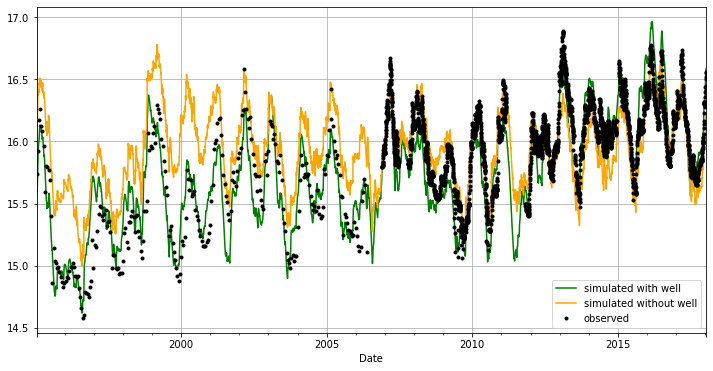

In [59]:
# create well model
ml_well = ml2.copy()
well = pd.read_csv("data/nb2/well_wellex.csv",
                   index_col="Date", parse_dates=True)
sm = ps.StressModel(well, rfunc=ps.Hantush, name="well",
                    settings="well", up=False)
ml_well.add_stressmodel(sm)
ml_well.solve()

# simulate groundwater levels
sim_well = ml_well.simulate()
sim_without_well = ml2.simulate()

fig, ax = plt.subplots(figsize=(12, 6))
sim_well.plot(ax=ax, label='simulated with well', color='g')
sim_without_well.plot(ax=ax, label='simulated without well', color='orange')
oseries2.plot(ax=ax, label='observed', ls='', marker='.', color='k')
ax.legend()
ax.grid()

#### Exercise 6 <a name="ex6"></a>

In the [answer](#ans2) of exercise 2 you can see that the time series of the stresses ends in 2020 while the observation series stops on the 5th of April 2018. The model is optimized for the period in which there are observations. We can used the optimized model to simulate groundwater heads after April 2018. For this simulation we use the full stress series and the relation between the stress and the groundwater levels in the optimized model. Simulate the groundwater levels between `5-4-2018` and `1-1-2020` using the `ml_wlvl` model of exercise 2.

<a href="#ans6">Answer Exercise 6</a>

#### Exercise 7 <a name="ex7"></a>
Visualise the results from exercise 6, show the following data:
- the simulated groundwater heads for the period of the observations. This is called the calibration period because the simulated groundwater levels where fitted on the observed groundwater levels in this period. 
- the simulated groundwater heads for the period after the last observation.
- the observed groundwater heads `oseries1`

<a href="#ans7">Answer Exercise 7</a>

#### Exercise 8 <a name="ex8"></a>

Another possibility is to fit the model on just a part of the observations. The other observations can be used to check if the model is able to mimick the groundwater heads (model validation). Create a model using the same time series you used for thet [Well Model](#well). Use the observation series between 1995 and 2014 to solve the model. Then simulate the groundwater heads for the period after 2014. Compare the simulation with measurements.

<a href="#ans8">Answer Exercise 8</a>

### 5. Step trend<a name="step"></a>

A step trend can be used in a time series model to simulate a sudden change in groundwater levels. This is often used to estimate the effect of hydrological measures on the groundwater. In the previous examples we only used the default stressmodel, conveniently named `StressModel`. For a step trend we use a different stressmodel named `StepModel`.

The `StepModel()` is fairly similar to the default `StressModel`. The only difference is that a `StepModel` already has some default settings to simulate step trends. The default settings include:
- `One` as the default response function (`rfunc=ps.rfunc.One`). This is a response function to model an instant effect of an external stress.
- A stress time series which is zero before a certain date (`tstart`) and one after this date.

#### Exercise 9 <a name="ex9"></a>
The [groundwater level time series](1_basic_pastas_model.ipynb#groundwater) that we used in the first notebook had a sudden change in groundwater levels. Use this time series to create a time series model with a step trend. The first steps are already done for you in the 2 code cells below. In the 3th code cell you have to write code yourself to add a step trend to the time series model, solve the model and visualise the results. The stressmodel can be created using `ps.stressmodels.StepModel()`.

In [34]:
# Import the time series from notebook 1
gwdata_raw = pd.read_csv('data/nb1/head_ex1.csv', parse_dates=True,
                         index_col='date', squeeze=True)
precip_mm = pd.read_csv('data/nb1/rain_ex4.csv', parse_dates=['date'],
                        index_col='date', squeeze=True)
evap_mm = pd.read_csv('data/nb1/evap_ex4.csv', parse_dates=['date'],
                      index_col='date', squeeze=True)
# convert units and get recharge
precip_m = precip_mm/1000
evap_m = evap_mm/1000
recharge = precip_m - evap_m

In [35]:
# create groundwater model with recharge
ml_step = ps.Model(gwdata_raw, name="GWL")
ts1 = ps.StressModel(recharge, ps.Gamma, name='recharge', settings="evap")
ml_step.add_stressmodel(ts1)

INFO: Cannot determine frequency of series head
INFO: Inferred frequency from time series None: freq=D 


In [37]:
# add step trend to the model (your code here)


<a href="#ans9">Answer Exercise 9</a>

### 6. Recharge<a name="recharge"></a>

In order to simulate the effect of precipitation and evaporation we have three methods:
1. 1 stressmodel with the recharge. As used in [chapter 1](#basicmodel) of this notebook. The recharge is computed as the precipitation - evaporation. In this case we end up with a single response function in which precipitation and the potential evaporation have the same weight.
2. Use 2 stressmodels, 1 for precipitation and 1 for evaporation. In this case we end up with 2 different response functions. 
3. Using `StressModel2` for the precipitation and the potential evaporation. This is a combination of method 1 and 2. The recharge is calculated as `recharge = precipitation - factor * evaporation`. The factor is a parameter that will be optimized when solving the model. This factor is often refered to as the evaporation factor. So we end up with a single response function and the evaporation factor.

Method 3 is the most common way to simulate the effect of precipitation and evaporation on groundwater levels. The evaporation factor allows us to adjust the weight of the potential evaporation compared to precipitation while the response to precipitation and evaporation remains the same.

#### Exercise 10 <a name="ex10"></a>

Apply the three methods to estimate the effect of precipitation and evaporation on groundwater levels on the `ml_wlvl` model from  [chapter 2](#surfacewater). What do you see in the results?

In [ ]:
# method 1


In [ ]:
# method 2


In [ ]:
# method 3


<a href="#ans10">Answer Exercise 10</a>

### 7. Summary<a name="summary"></a>

So far, we've shown time series models with different external stresses: recharge, surface water, well extraction and a step trend. We included the external stress in the time series model using a stressmodel. In the stressmodel we defined the time series of the stress and the shape of the response function (`rfunc`). The following pre-defined response functions from Pastas were used:
- Gamma: precipitation, evaporation and recharge
- Exponential: surface water levels
- Hantush: extraction wells
- One: step trend

Apart from the response functions we also used different stressmodels to simulate the effect of different external stresses. We used:
- `StressModel`: default stressmodel to simulate any external stress
- `Stressmodel2`: to simulate the effect of precipitation and potential evaporation with the same response function and a weighing factor (evaporation factor) for the precipitation and potential evaporation.
- `StepModel`: a stressmodel with pre-defined settings to simulate a step trend.


## Answers

#### <a href="#ex1">Answer exercise 1</a> <a name="ans1"></a>

The fit between observed and simulated groundwater heads is poor because the groundwater levels are simulated using only recharge. Around 2011 and 2017 there was clearly another external influence on the groundwater that was not considered in the time series model. In this case the groundwater levels depend on surface water levels in a nearby river. 

#### <a href="#ex2">Answer exercise 2</a> <a name="ans2"></a>

**some background**:
The measurements well is next to the Meuse and the waterlevels used are also from this river. The surface water level dropped around 2017 suddenly due to an [accident at a weir (Dutch)](https://nl.wikipedia.org/wiki/Ongeval_op_de_Maas_met_de_stuw_Grave). This caused the groundwater level to drop as well.

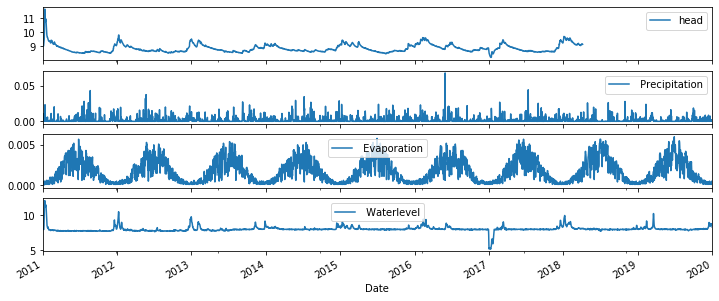

In [7]:
# read water levels
waterlevel = pd.read_csv("data/nb2/waterlevel.csv",
                         parse_dates=True,  squeeze=True, index_col=0)

# visualise water levels
fig, axes = plt.subplots(4, 1, figsize=(12, 5), sharex=True)
oseries1.plot(ax=axes[0], x_compat=True, legend=True)
rain1.plot(ax=axes[1], x_compat=True, legend=True)
evap1.plot(ax=axes[2], x_compat=True, legend=True)
waterlevel.plot(ax=axes[3], x_compat=True, legend=True)

#### <a href="#ex3">Answer exercise 3</a> <a name="ans3"></a>

some things you can see in the result figure below:
- The fit between simulated and observed groundwater heads improved dramatically (EVP was 64.39% and is 86,6% now). 
- the contributions of the stresses (recharge and waterlevels) are shown seperately.
- The simulated groundwater head is the sum of the contributions from each stress and the constant_d (shown in the model information on the top right).
- In the response functions on the bottom right you can see that the response to recharge is relatively slow and the response to water level fluctuations is fast.

''

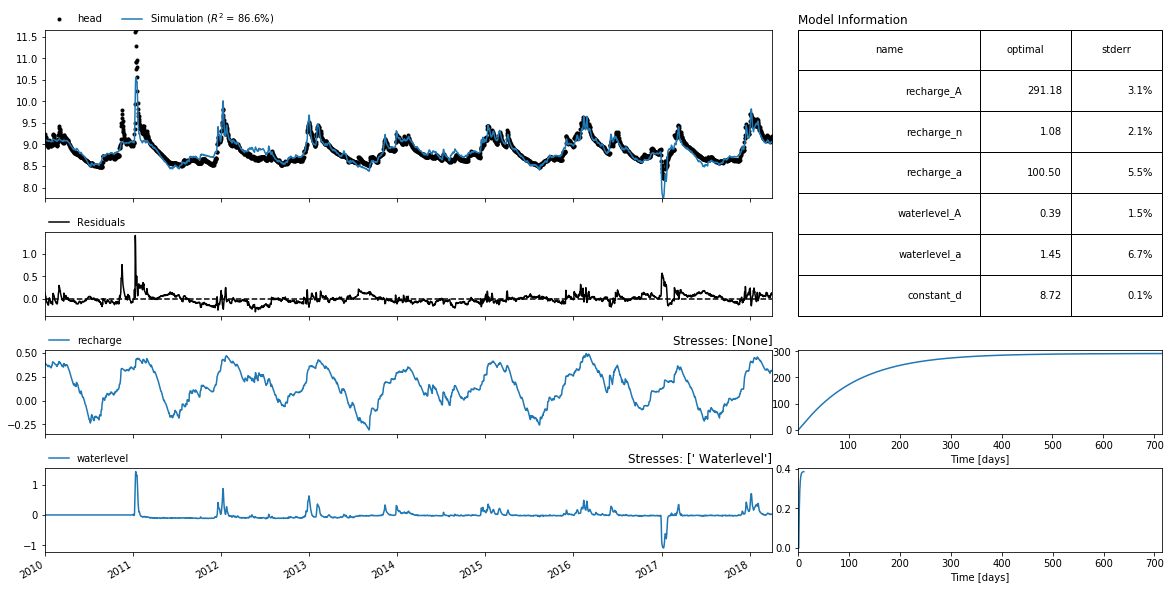

In [8]:
ml_wlvl.plots.results(figsize=(16, 8))
;

#### <a href="#ex4">Answer exercise 4</a> <a name="ans4"></a>

INFO: Cannot determine frequency of series  Head
INFO: Inferred frequency from time series  Well: freq=D 


Model Results  Head_copy            Fit Statistics
nfev     46                     EVP          75.30
nobs     3869                   R2            0.75
noise    True                   RMSE          0.18
tmin     1995-01-14 00:00:00    AIC          15.52
tmax     2018-01-12 00:00:00    BIC          71.87
freq     D                      ___               
warmup   3650 days 00:00:00     ___               
solver   LeastSquares           ___               

Parameters (9 were optimized)
                optimal   stderr     initial  vary
recharge_A   534.274964   ±9.64%  203.104730  True
recharge_n     1.368282   ±1.55%    1.000000  True
recharge_a    65.043043   ±8.61%   10.000000  True
recharge_f    -0.551597  ±10.61%   -1.000000  True
well_A        -0.000098  ±11.81%   -0.000338  True
well_rho       1.554558  ±56.19%    1.000000  True
well_cS      114.616179  ±72.22%  100.000000  True
constant_d    15.457308   ±0.80%   15.975755  True
noise_alpha  104.542748  ±18.23%    1.000000  True


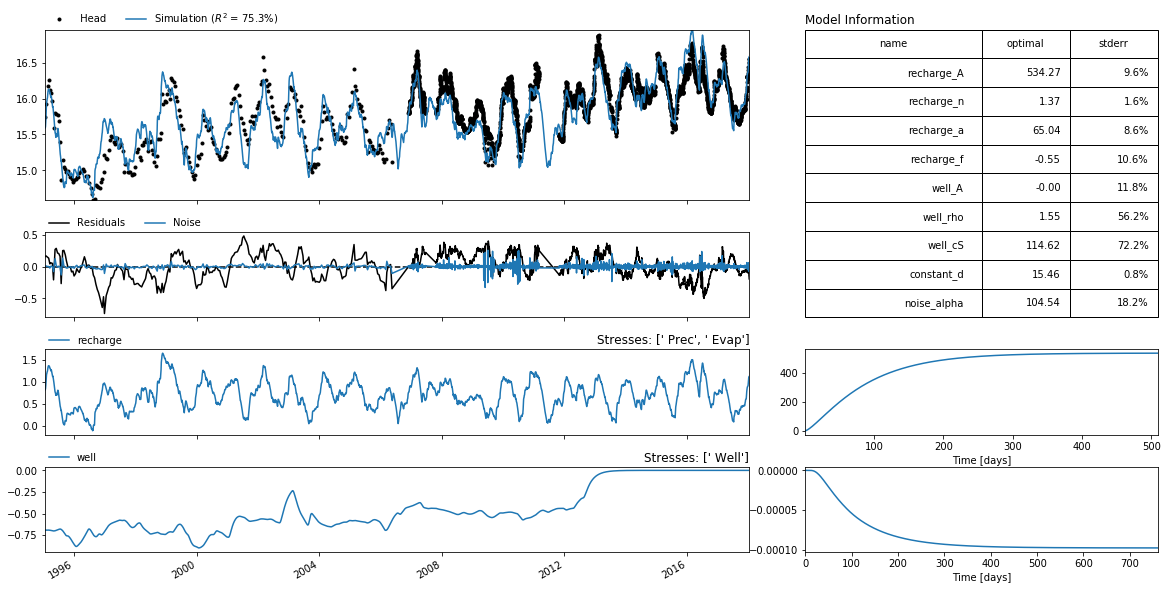

In [9]:
# create new model
ml_well = ml2.copy()

# read extraction rate time series
well = pd.read_csv("data/nb2/well_wellex.csv",
                   index_col="Date", parse_dates=True)

# add extraction rates to the model
sm = ps.StressModel(well, rfunc=ps.Hantush, name="well",
                    settings="well", up=False)
ml_well.add_stressmodel(sm)

# solve and show results
ml_well.solve()
ml_well.plots.results(figsize=(16, 8))

#### <a href="#ex5">Answer exercise 5</a> <a name="ans5"></a>

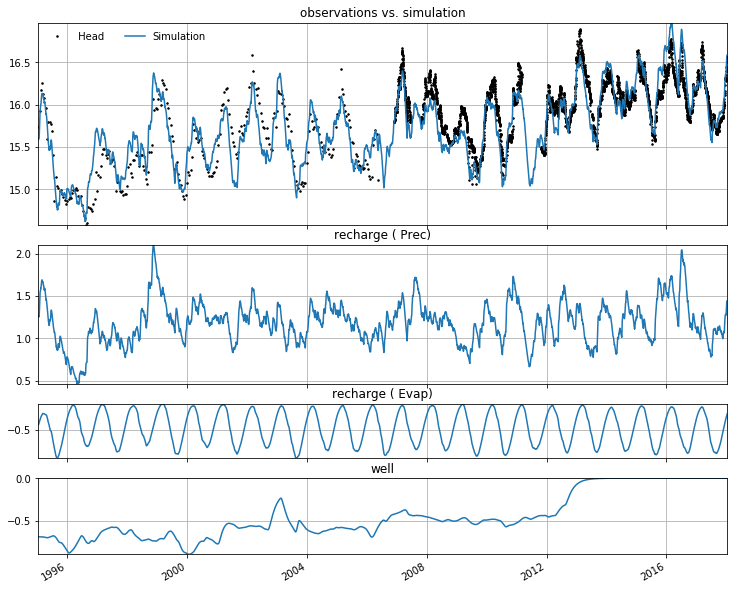

In [10]:
axes = ml_well.plots.decomposition()

#### <a href="#ex6">Answer exercise 6</a> <a name="ans6"></a>

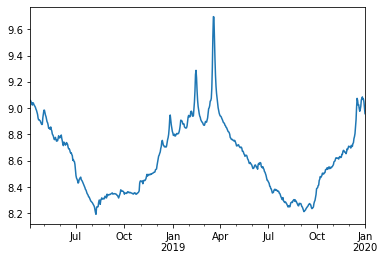

In [11]:
sim_wlvl2020 = ml_wlvl.simulate(tmin='2018-4-5', tmax='2020-1-1')
sim_wlvl2020.plot()

#### <a href="#ex7">Answer exercise 7</a> <a name="ans7"></a>

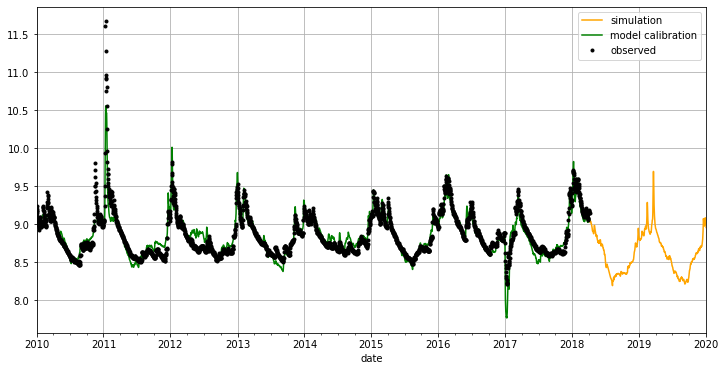

In [12]:
sim_wlvl = ml_wlvl.simulate()

fig, ax = plt.subplots(figsize=(12, 6))
sim_wlvl2020.plot(ax=ax, label='simulation', color='orange')
sim_wlvl.plot(ax=ax, label='model calibration', color='g')
oseries1.plot(ax=ax, label='observed', ls='', marker='.', color='k')
ax.legend()
ax.grid()

#### <a href="#ex8">Answer exercise 8</a> <a name="ans8"></a>

INFO: Cannot determine frequency of series  Head
INFO: Inferred frequency from time series  Prec: freq=D 
INFO: Inferred frequency from time series  Evap: freq=D 
INFO: Inferred frequency from time series  Well: freq=D 


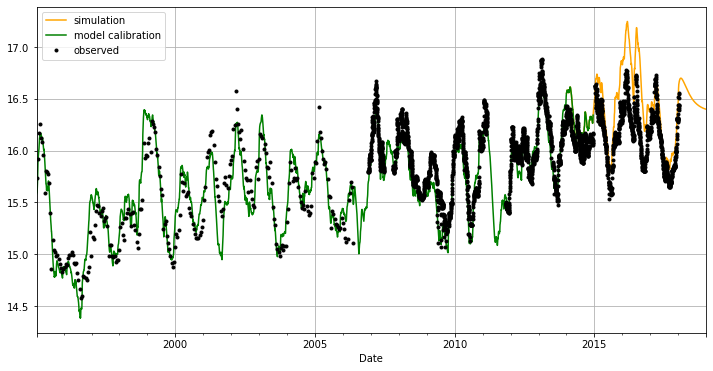

In [13]:
# slice oseries
start_cal = '1994'
end_cal = '2014'
oseries_well2 = oseries2.loc[start_cal:end_cal]

# create model
ml_well2 = ps.Model(oseries_well2)
sm = ps.StressModel2([rain2, evap2], rfunc=ps.Gamma, name="recharge")
ml_well2.add_stressmodel(sm)
sm2 = ps.StressModel(well, rfunc=ps.Hantush, name="well",
                     settings="well", up=False)
ml_well2.add_stressmodel(sm2)

# solve model
ml_well2.solve(report=False)

# simulate groundwater levels
sim_well_cal = ml_well2.simulate()
sim_well_val = ml_well2.simulate(tmin=end_cal, tmax='2019')

# visualise results
fig, ax = plt.subplots(figsize=(12, 6))
sim_well_val.plot(ax=ax, label='simulation', color='orange')
sim_well_cal.plot(ax=ax, label='model calibration', color='g')
oseries2.plot(ax=ax, label='observed', ls='', marker='.', color='k')
ax.legend()
ax.grid()

#### <a href="#ex9">Answer exercise 9</a> <a name="ans9"></a>

INFO: Cannot determine frequency of series head
INFO: Inferred frequency from time series None: freq=D 


''

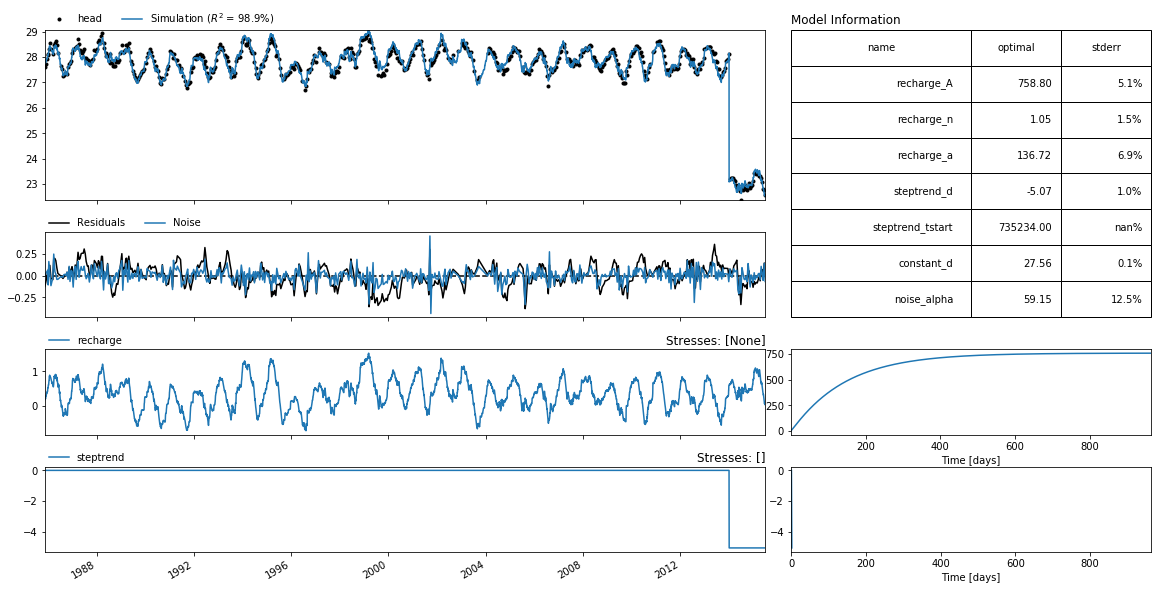

In [57]:
# Import the time series from notebook 1
gwdata_raw = pd.read_csv('data/nb1/head_ex1.csv', parse_dates=True,
                         index_col='date', squeeze=True)
precip_mm = pd.read_csv('data/nb1/rain_ex4.csv', parse_dates=['date'],
                        index_col='date', squeeze=True)
evap_mm = pd.read_csv('data/nb1/evap_ex4.csv', parse_dates=['date'],
                      index_col='date', squeeze=True)
# convert units and get recharge
precip_m = precip_mm/1000
evap_m = evap_mm/1000
recharge = precip_m - evap_m

# create groundwater model with recharge
ml_step = ps.Model(gwdata_raw, name="GWL")
ts1 = ps.StressModel(recharge, ps.Gamma, name='recharge', settings="evap")
ml_step.add_stressmodel(ts1)

# add stepmodel (your code here)
step = ps.stressmodels.StepModel(tstart='2014-1-1', name='steptrend')
ml_step.add_stressmodel(step)

ml_step.solve(report=False)
ml_step.plots.results(figsize=(16, 8))
;

#### <a href="#ex9">Answer exercise 10</a> <a name="ans10"></a>

You can see that method 1 and 3 both have good results. The fit with method 2 is a lot worse. This is probably because this model is overparameterized.

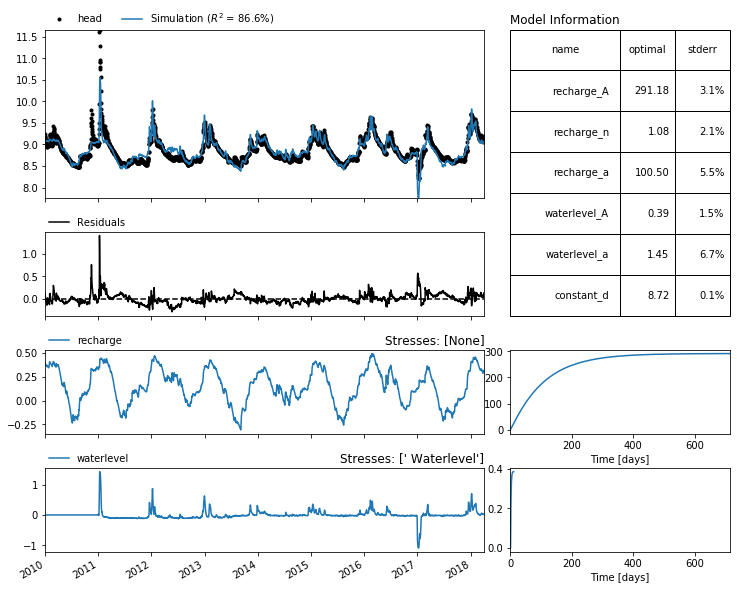

In [56]:
# method 1 was already used so we only plot results
ml_wlvl.plots.results()
;

INFO: Cannot determine frequency of series head
INFO: Inferred frequency from time series  Precipitation: freq=D 
INFO: Inferred frequency from time series  Evaporation: freq=D 


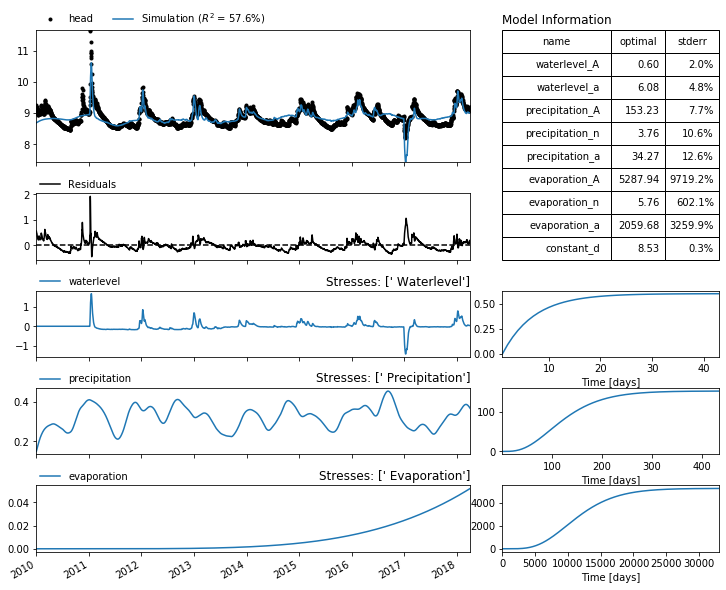

In [54]:
# method 2
ml_wlvl_method2 = ml_wlvl.copy()
ml_wlvl_method2.del_stressmodel('recharge')
sm1 = ps.StressModel(rain1, rfunc=ps.Gamma, name="precipitation")
sm2 = ps.StressModel(evap1, rfunc=ps.Gamma, name='evaporation')
ml_wlvl_method2.add_stressmodel(sm1)
ml_wlvl_method2.add_stressmodel(sm2)
ml_wlvl_method2.solve(noise=False, report=False)
ml_wlvl_method2.plots.results()
;

INFO: Cannot determine frequency of series head
INFO: Inferred frequency from time series  Precipitation: freq=D 
INFO: Inferred frequency from time series  Evaporation: freq=D 


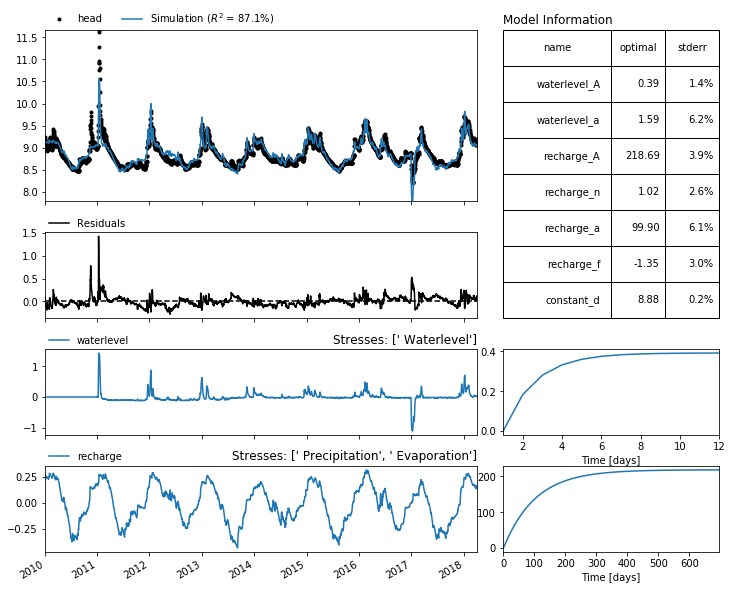

In [53]:
# method 3
ml_wlvl_method3 = ml_wlvl.copy()
ml_wlvl_method3.del_stressmodel('recharge')

sm2_rech = ps.StressModel2([rain1, evap1], rfunc=ps.Gamma, name="recharge")
ml_wlvl_method3.add_stressmodel(sm2_rech)
ml_wlvl_method3.solve(noise=False, report=False)
ml_wlvl_method3.plots.results()
;

### Origin of the series

Model with surface water levels:
* The rainfall and evaporation data is taken from weather station Volkel in The Netherlands.
* The head data is well B46B0703-001, which was obtained from Dino loket
* The waterlevel data is from station Gennep obtained via waterinfo.rws.nl

Model with well extraction rates obtained from this [notebook](https://github.com/pastas/pastas/blob/master/examples/notebooks/7_%20well_example.ipynb)